In [18]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def mean_square_error(y, y_exp):
    ''' Compute the Mean Square Error bewteen 2 arrays (y and y_exp) '''
    residus = (y - y_exp)
    return np.sum(residus**2) / len(y)

In [25]:
class curve_fitting():
    def __init__(self):
        ''' Parameters values (X), 
        number of points for the curve (nb_points),
        abscisse curve points (x) '''
        self.X = 0.5 * np.ones(2)
        self.nb_points = 30
        self.x = np.linspace(0, 1, self.nb_points)
        
    def scale_parameters(self, X_raw):
        ''' Return scaled parameters between [0, 1] for gradient convergence optimization '''
        X0 = ( X_raw[0] - 0 ) / ( 2000 - 0 )
        X1 = ( X_raw[1] - 0.01 ) / ( 0.5 - 0.01 )
        return np.array([X0, X1])
    
    def unscale_parameters(self):
        ''' Return unscaled parameters between [min, max] for computing function '''
        X0 = self.X[0] * ( 2000 - 0 ) + 0
        X1 = self.X[1] * ( 0.5 - 0.01 ) + 0.01
        return np.array([X0, X1])
    
    def print_parameters(self):
        ''' Print value of raw and scaled parameters '''
        X_raw = self.unscale_parameters()
        print(f'Raw parameters {X_raw}')
        print(f'Scaled parameters {np.round(self.X, 2)}')
    
    def set_parameters_norm(self, X):
        ''' Update parameters values (scaled or norm) '''
        self.X = X
    
    def set_parameters_raw(self, X_raw):
        ''' Update parameters values (given raw values) '''
        X = self.scale_parameters(X_raw)
        self.X = X
        
    def function(self):
        ''' Define the function to fit using parameters X[i] '''
        X = self.unscale_parameters()
        return X[0] * self.x ** X[1]
    
    def optim(self, lamdba = 0.01, mu = 0.95, steps=10, delta = 0.001, y_exp=None, debug=False):
        ''' Perform Levenberg Marquardt optimization '''
        print(f'X init: {self.X}')
        y = self.function()
        error = mean_square_error(y, y_exp)
        errors = [error]

        for step in range(steps):
            y = self.function()
            error = mean_square_error(y, y_exp)
            print(f'Iteration {step}: error = {np.round(error)}')
            errors.append(error)
            
            ''' Compute jacobian with finite difference method 
            for each curve point (y) and each parameter (X) '''
            J = np.zeros((len(y), len(self.X)))
            for i in range(len(self.X)):
                X2 = self.X.copy()  
                X2[i] = X2[i] + delta
                self.set_parameters_norm(X2)
                Y2 = self.function()
                X3 = self.X.copy()  
                X3[i] = X3[i] - delta
                self.set_parameters_norm(X3)
                Y3 = self.function()
                J[:, i] = (Y2 - Y3) / (2*delta)
            
            JJ = np.dot(np.transpose(J), J)
            G = np.dot(np.linalg.inv( JJ + mu * np.diag(np.diag(JJ)))  , np.transpose(J))
            X = self.X + np.dot(G, (y_exp-y))
            self.set_parameters_norm(X)
            
            if debug:
                print(f'jacobian: {J}')
                print(f'gradient: {np.dot(np.transpose(J), y-y_exp)}')
                print(f'G: {G}')
                print(f'np.dot(G, (y_exp-y): {np.dot(G, (y_exp-y))}')
                print(f'next iteration: {X}')
        
        fig, ax = plt.subplots(1, 2)
        plt.title('Levenberg Marquardt Curve Fitting')
        ax[0].plot(self.x, y, linestyle='dashed', color='red')
        ax[0].scatter(self.x, y_exp, color='grey', alpha=0.9)
        ax[0].title.set_text('Fitted experimental points')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
        
        ax[1].plot(errors, color='black')
        ax[1].title.set_text('Convergence')
        ax[1].set_xlabel('iterations')
        ax[1].set_ylabel('mean square error')
        
        fig.tight_layout()
        plt.show()

In [21]:
def generate_experimental_noisy_points(X, nb_points):
    ''' Simulation the generation of noisy experimental dataset 
    from true parameters values (set_parameters_raw([600, 0.15])) and number of points (nb_points) '''
    noisy_model = curve_fitting()
    noisy_model.set_parameters_raw([600, 0.15])
    target = noisy_model.function()
    noise = 0.15 * np.random.random(nb_points) * target
    return target + noise

Raw parameters [1.00e+03 2.55e-01]
Scaled parameters [0.5 0.5]
X init: [0.5 0.5]
Iteration 0: error = 63423.0
Iteration 1: error = 5192.0
Iteration 2: error = 1351.0
Iteration 3: error = 666.0
Iteration 4: error = 493.0
Iteration 5: error = 448.0
Iteration 6: error = 435.0
Iteration 7: error = 432.0
Iteration 8: error = 430.0
Iteration 9: error = 430.0


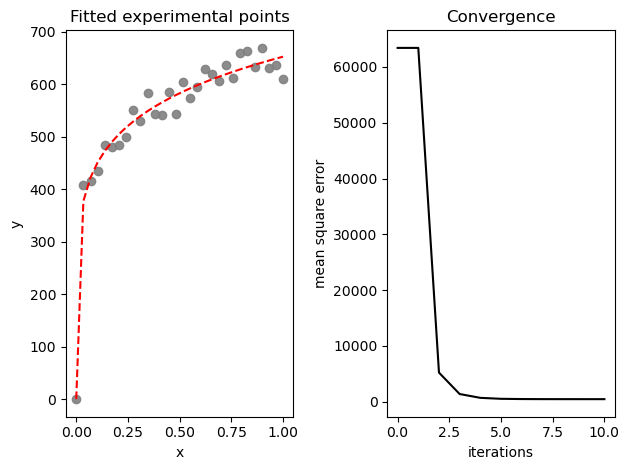

Raw parameters [6.52225026e+02 1.62311697e-01]
Scaled parameters [0.33 0.31]


In [27]:
# Initiate model 
model = curve_fitting()

# generate noisy dataset
model.print_parameters()
y_exp = generate_experimental_noisy_points(X=[1500,0.3], nb_points=30)

# perform curve fitting optimization
model.optim(lamdba = 0.001, mu = 0.95, steps=10, delta = 0.001, y_exp=y_exp, debug=False)
model.print_parameters()